# <span style="color:#F72585"><center>Análisis Exploratorio de Modelos Bayesianos</center></span>


<center>(Pyro)<center>

## <span style="color:#4361EE">Introducción</span>


Se introducen los elementos esenciales del análisis exploratorio de  Modelos Bayesianos. Usaremos la librería [Arviz](https://arviz-devs.github.io/arviz/) que es una librería desarrollada para hacer estos análisis en Python. 

En particular, Arviz puede trabajar con las salidas de Pyro.

En este cuaderno usamos el ejemplo de 8 escuelas (eight schools) que utilizamos en el [primer ejemplo de Stan en este curso](Stan_Ejemplo_1_eight_schools.ipynb)





## <span style="color:#4361EE">El modelo estadístico para este tutorial</span>


Supongamos que tenemos observaciones $[y_n |x_n], n=1,\ldots,N$, y asumamos el modelo Bayesiano. 

**Modelo con efectos aleatorios**

- Estima los hiperparámetros $\mu$ and $\tau$
- Predice los efectos aleatorios $\eta_i$


$$
\begin{align}
y_i &\sim \mathcal{N}(\theta_i,\sigma_i^2), \text{ known } \sigma_i^2\\
\theta_i & = \mu + \tau \times \eta_i \\
\eta_i &\sim \mathcal{N}(0, 1)\\
\mu &\sim \mathcal{N}(0, 5)\\
\tau &\sim \mathcal{Cauchy}(0, 5)1_{\tau>0.0}
\end{align}
$$



### <span style="color:#4CC9F0">Los datos</span>

Los datos corresponden a la estimación (estandarizada) de un puntaje realizada en las ocho escuelas observadas.


```{table}
|School |Estim. Treatment Effect | Estim. Stand. Error |
|---|---|---|
|A |28| 15|
|B |8 |10|
|C| -3| 16|
|D| 7| 11|
|E| -1 |9|
|F| 1| 11|
|G |18| 10|
|H| 12| 18|
```

In [45]:
import torch
import numpy as np

In [46]:
# Los datos
schools = np.array(['Choate', 'Deerfield', 'Phillips Andover', 'Phillips Exeter',
                    'Hotchkiss', 'Lawrenceville', "St. Paul's", 'Mt. Hermon'])

schools_dat = {
    "J": 8,
    "y": torch.tensor([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0]),
    "sigma": torch.tensor([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0]),
}


## <span style="color:#4361EE">Implementación del modelo estadístico en Pyro</span>


In [47]:
import pyro
import pyro.distributions as dist
import pyro.distributions.constraints as constraints
from pyro.infer import MCMC, NUTS, Predictive


In [48]:
def model(J, sigma, y=None):
    mu = pyro.sample("mu", dist.Normal(0, 5))
    tau = pyro.sample("tau", dist.HalfCauchy(5))
    with pyro.plate("J", J):
        eta = pyro.sample("eta", dist.Normal(0, 1))
        theta = mu + tau * eta
        return pyro.sample("obs", dist.Normal(theta, sigma), obs=y)  


En este código los parámetros que serán muestreados son $\mu$ (*media gl0bal*), $\tau$ (*desviación estándar*), y los $\eta_i$ (*eta*) que son los efectos aleatorios en el modelo. Las medias $\theta_i$ de las escuelas son calculados. Es decir, son funcionales de los parámetros.

Hemos asumido las distribuciones a priori para $\mu\sim \mathcal{N}(0,5)$,  $\tau\sim \mathcal{Cauchy}(0,5)1_{\tau>0.0}$ y $\eta_i \sim \mathcal{N}(0,1)$.

    

## <span style="color:#4361EE">Compilación del modelo</span>


In [49]:
nuts_kernel = NUTS(model, jit_compile=True, ignore_jit_warnings=True)
mcmc = MCMC(nuts_kernel,
    num_samples=500,
    warmup_steps=500,
    num_chains=7)
mcmc.run(**schools_dat)
posterior_samples = mcmc.get_samples()
posterior_predictive = Predictive(model, posterior_samples)(
    schools_dat["J"], schools_dat["sigma"]
)
prior = Predictive(model, num_samples=500)(
    schools_dat["J"], schools_dat["sigma"]
)

Sample: 100%|██████████| 1000/1000 [00:20, 48.77it/s, step size=4.86e-01, acc. prob=0.900]


In [50]:
 mcmc.summary(prob=0.5)


                mean       std    median     25.0%     75.0%     n_eff     r_hat
    eta[0]      0.32      1.07      0.36     -0.04      1.37    663.36      1.00
    eta[1]      0.09      0.92      0.16     -0.39      0.72    586.87      1.00
    eta[2]     -0.08      0.89     -0.09     -0.77      0.38    546.05      1.00
    eta[3]      0.08      0.84      0.08     -0.21      0.79    713.93      1.00
    eta[4]     -0.13      0.90     -0.16     -0.78      0.35    508.82      1.00
    eta[5]     -0.02      0.89     -0.03     -0.50      0.79    628.34      1.00
    eta[6]      0.35      0.99      0.39     -0.42      0.89    516.88      1.00
    eta[7]      0.11      0.93      0.09     -0.43      0.84    671.05      1.00
        mu      4.38      3.02      4.31      2.28      6.13    756.63      1.00
       tau      3.63      3.32      2.69      0.06      2.77    416.54      1.00

Number of divergences: 0


## <span style="color:#4361EE">Inferencia. InferenceData(ArviZ)</span>


Para seguir esta parte del tutorial localmente por favor instale ArviZ.

Desde la linea de comandos: 

*pip install arviz*

o mejor use

*conda install -c conda-forge arviz*

In [51]:
# Importamos las librerías requeridas.

import arviz as az
import numpy as np
import pandas as pd
import xarray

# definimos estilos para el fondo de los gráficos y para mostrar la información
az.style.use('arviz-darkgrid')
xarray.set_options(display_style="html");

In [52]:
pyro_data = az.from_pyro(
    mcmc,
    posterior_predictive = posterior_predictive,
    coords={'school': schools },
    prior=prior,
    dims={
        "theta": ["school"],
        'y': ['school'],
        'eta': ['school'],
    }
)


In [53]:
pyro_data

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

In [54]:
pyro_data.posterior

<xarray.Dataset>
Dimensions:  (chain: 1, draw: 500, school: 8)
Coordinates:
  * chain    (chain) int32 0
  * draw     (draw) int32 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499
  * school   (school) <U16 'Choate' 'Deerfield' ... "St. Paul's" 'Mt. Hermon'
Data variables:
    eta      (chain, draw, school) float32 0.1916 1.419 0.05984 ... 2.482 2.486
    mu       (chain, draw) float32 5.485 5.582 5.954 1.226 ... 4.88 3.421 5.475
    tau      (chain, draw) float32 9.954 4.909 2.85 11.81 ... 3.012 4.485 3.68
Attributes:
    created_at:                 2022-11-02T00:27:55.711092
    arviz_version:              0.13.0
    inference_library:          pyro
    inference_library_version:  1.8.2

In [55]:
pyro_data.posterior.all

<bound method DatasetReductions.all of <xarray.Dataset>
Dimensions:  (chain: 1, draw: 500, school: 8)
Coordinates:
  * chain    (chain) int32 0
  * draw     (draw) int32 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499
  * school   (school) <U16 'Choate' 'Deerfield' ... "St. Paul's" 'Mt. Hermon'
Data variables:
    eta      (chain, draw, school) float32 0.1916 1.419 0.05984 ... 2.482 2.486
    mu       (chain, draw) float32 5.485 5.582 5.954 1.226 ... 4.88 3.421 5.475
    tau      (chain, draw) float32 9.954 4.909 2.85 11.81 ... 3.012 4.485 3.68
Attributes:
    created_at:                 2022-11-02T00:27:55.711092
    arviz_version:              0.13.0
    inference_library:          pyro
    inference_library_version:  1.8.2>

In [56]:
pyro_data.posterior.mu

<xarray.DataArray 'mu' (chain: 1, draw: 500)>
array([[ 5.48496532e+00,  5.58247662e+00,  5.95368814e+00,
         1.22637320e+00,  3.33348155e-01,  1.01098976e+01,
         1.61953199e+00,  4.02104759e+00,  3.53440666e+00,
         6.26776600e+00,  7.11896276e+00,  3.15258956e+00,
         5.65273809e+00,  4.37945080e+00, -1.99665427e-01,
         9.13485527e+00,  2.39072752e+00,  2.28031683e+00,
         5.79644585e+00,  5.18808365e+00,  3.61312628e+00,
         1.00455618e+00,  8.62271309e+00,  3.65124893e+00,
         3.93549800e+00,  4.85046864e+00,  5.78514862e+00,
         7.72550106e+00,  7.63975525e+00,  4.92010832e-01,
        -7.39756584e-01,  7.33882141e+00,  5.49453306e+00,
         2.97278881e+00,  6.85331869e+00,  7.48870754e+00,
        -2.77655840e+00,  9.13908386e+00,  2.69992805e+00,
         6.28597975e+00,  2.90165234e+00,  1.12410355e+00,
         1.53044939e+00,  5.95509720e+00,  3.11959577e+00,
         5.76558638e+00,  2.90182304e+00,  6.53605413e+00,
         7.51938057e+00,  8.17197323e+00,  3.29129529e+00,
        -6.41418278e-01,  9.58305168e+00, -1.50107837e+00,
        -3.70955420e+00,  4.87391281e+00,  4.09040308e+00,
         4.65214396e+00,  5.34864712e+00,  5.49034357e+00,
...
         1.52339685e+00,  4.62369490e+00,  2.89760232e+00,
        -1.01937509e+00,  3.77926135e+00,  3.08526611e+00,
         1.36721766e+00,  2.09768653e+00,  5.72998047e+00,
         6.13131237e+00,  4.61896563e+00,  6.11728621e+00,
         2.77211380e+00,  6.11880064e+00,  2.76408648e+00,
         9.24364471e+00,  1.03504820e+01, -3.47104549e-01,
        -1.03212917e+00,  4.25361347e+00,  5.87963533e+00,
         3.36349177e+00,  1.10079598e+00,  7.49890947e+00,
         7.73050690e+00,  3.94584680e+00,  2.47910452e+00,
         6.22813845e+00,  2.87481737e+00,  4.48031521e+00,
         4.66794968e+00,  4.14521074e+00,  4.49777269e+00,
         4.57925987e+00,  2.87403202e+00,  9.71882403e-01,
         2.73015547e+00,  5.93787003e+00,  4.49329472e+00,
         5.06377125e+00,  4.12997341e+00,  9.04969311e+00,
         7.35563338e-01,  2.51397157e+00,  2.86235005e-01,
         5.13003540e+00,  4.89005232e+00,  5.71523094e+00,
         5.31386852e+00,  4.15657711e+00,  4.84147120e+00,
         8.64707410e-01, -3.27998400e-02,  9.62208366e+00,
         9.25133228e+00, -1.04589105e+00,  4.88005304e+00,
         3.42114186e+00,  5.47518063e+00]], dtype=float32)
Coordinates:
  * chain    (chain) int32 0
  * draw     (draw) int32 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499

In [57]:
val = pyro_data.posterior.mu[0,300]
print(val)
print('np.array(val) = ' ,np.array(val))

<xarray.DataArray 'mu' ()>
array(5.4079223, dtype=float32)
Coordinates:
    chain    int32 0
    draw     int32 300
np.array(val) =  5.4079223


In [58]:
pyro_data.sample_stats

<xarray.Dataset>
Dimensions:    (chain: 1, draw: 500)
Coordinates:
  * chain      (chain) int32 0
  * draw       (draw) int32 0 1 2 3 4 5 6 7 ... 492 493 494 495 496 497 498 499
Data variables:
    diverging  (chain, draw) bool False False False False ... False False False
Attributes:
    created_at:                 2022-11-02T00:27:55.960628
    arviz_version:              0.13.0
    inference_library:          pyro
    inference_library_version:  1.8.2

In [59]:
pyro_data.log_likelihood

<xarray.Dataset>
Dimensions:    (chain: 1, draw: 500, obs_dim_0: 8)
Coordinates:
  * chain      (chain) int32 0
  * draw       (draw) int32 0 1 2 3 4 5 6 7 ... 492 493 494 495 496 497 498 499
  * obs_dim_0  (obs_dim_0) int32 0 1 2 3 4 5 6 7
Data variables:
    obs        (chain, draw, obs_dim_0) float32 -4.571 -3.895 ... -3.279 -3.82
Attributes:
    created_at:                 2022-11-02T00:27:56.201358
    arviz_version:              0.13.0
    inference_library:          pyro
    inference_library_version:  1.8.2

In [60]:
pyro_data.posterior_predictive

<xarray.Dataset>
Dimensions:    (chain: 1, draw: 500, obs_dim_0: 8)
Coordinates:
  * chain      (chain) int32 0
  * draw       (draw) int32 0 1 2 3 4 5 6 7 ... 492 493 494 495 496 497 498 499
  * obs_dim_0  (obs_dim_0) int32 0 1 2 3 4 5 6 7
Data variables:
    obs        (chain, draw, obs_dim_0) float32 2.782 4.235 ... 5.749 20.76
Attributes:
    created_at:                 2022-11-02T00:27:56.438920
    arviz_version:              0.13.0
    inference_library:          pyro
    inference_library_version:  1.8.2

In [61]:
pyro_data.observed_data

<xarray.Dataset>
Dimensions:    (obs_dim_0: 8)
Coordinates:
  * obs_dim_0  (obs_dim_0) int32 0 1 2 3 4 5 6 7
Data variables:
    obs        (obs_dim_0) float32 28.0 8.0 -3.0 7.0 -1.0 1.0 18.0 12.0
Attributes:
    created_at:                 2022-11-02T00:27:57.155217
    arviz_version:              0.13.0
    inference_library:          pyro
    inference_library_version:  1.8.2

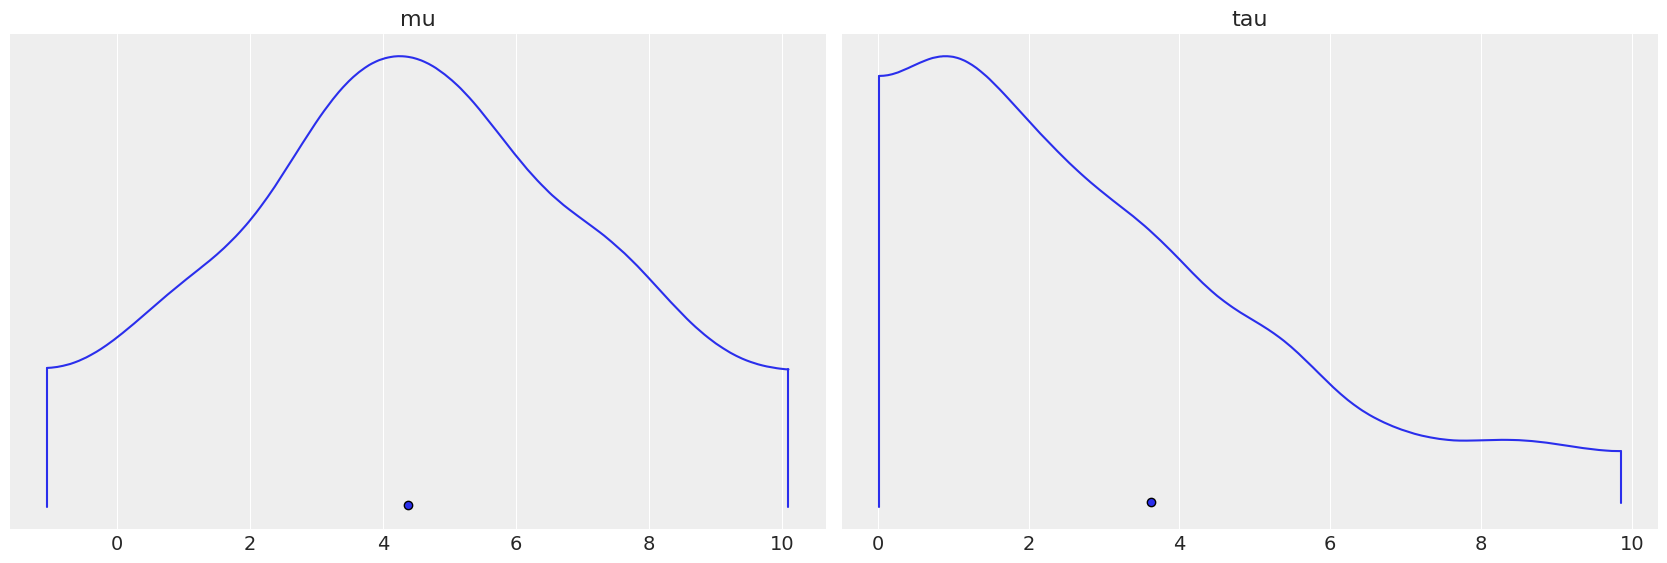

In [62]:
az.plot_density(pyro_data, var_names=['mu', 'tau']);

In [63]:
az.plot_density?

Signature:
az.plot_density(
    data,
    group='posterior',
    data_labels=None,
    var_names=None,
    filter_vars=None,
    combine_dims=None,
    transform=None,
    hdi_prob=None,
    point_estimate='auto',
    colors='cycle',
    outline=True,
    hdi_markers='',
    shade=0.0,
    bw='default',
    circular=False,
    grid=None,
    figsize=None,
    textsize=None,
    labeller=None,
    ax=None,
    backend=None,
    backend_kwargs=None,
    show=None,
)
Docstring:
Generate KDE plots for continuous variables and histograms for discrete ones.

Plots are truncated at their 100*(1-alpha)% highest density intervals. Plots are grouped per
variable and colors assigned to models.

Parameters
----------
data : Union[Object, Iterator[Object]]
    Any object that can be converted to an :class:`arviz.InferenceData` object, or an Iterator
    returning a sequence of such objects.
    Refer to documentation of :func:`arviz.convert_to_dataset` for details about such objects.
group: Optiona

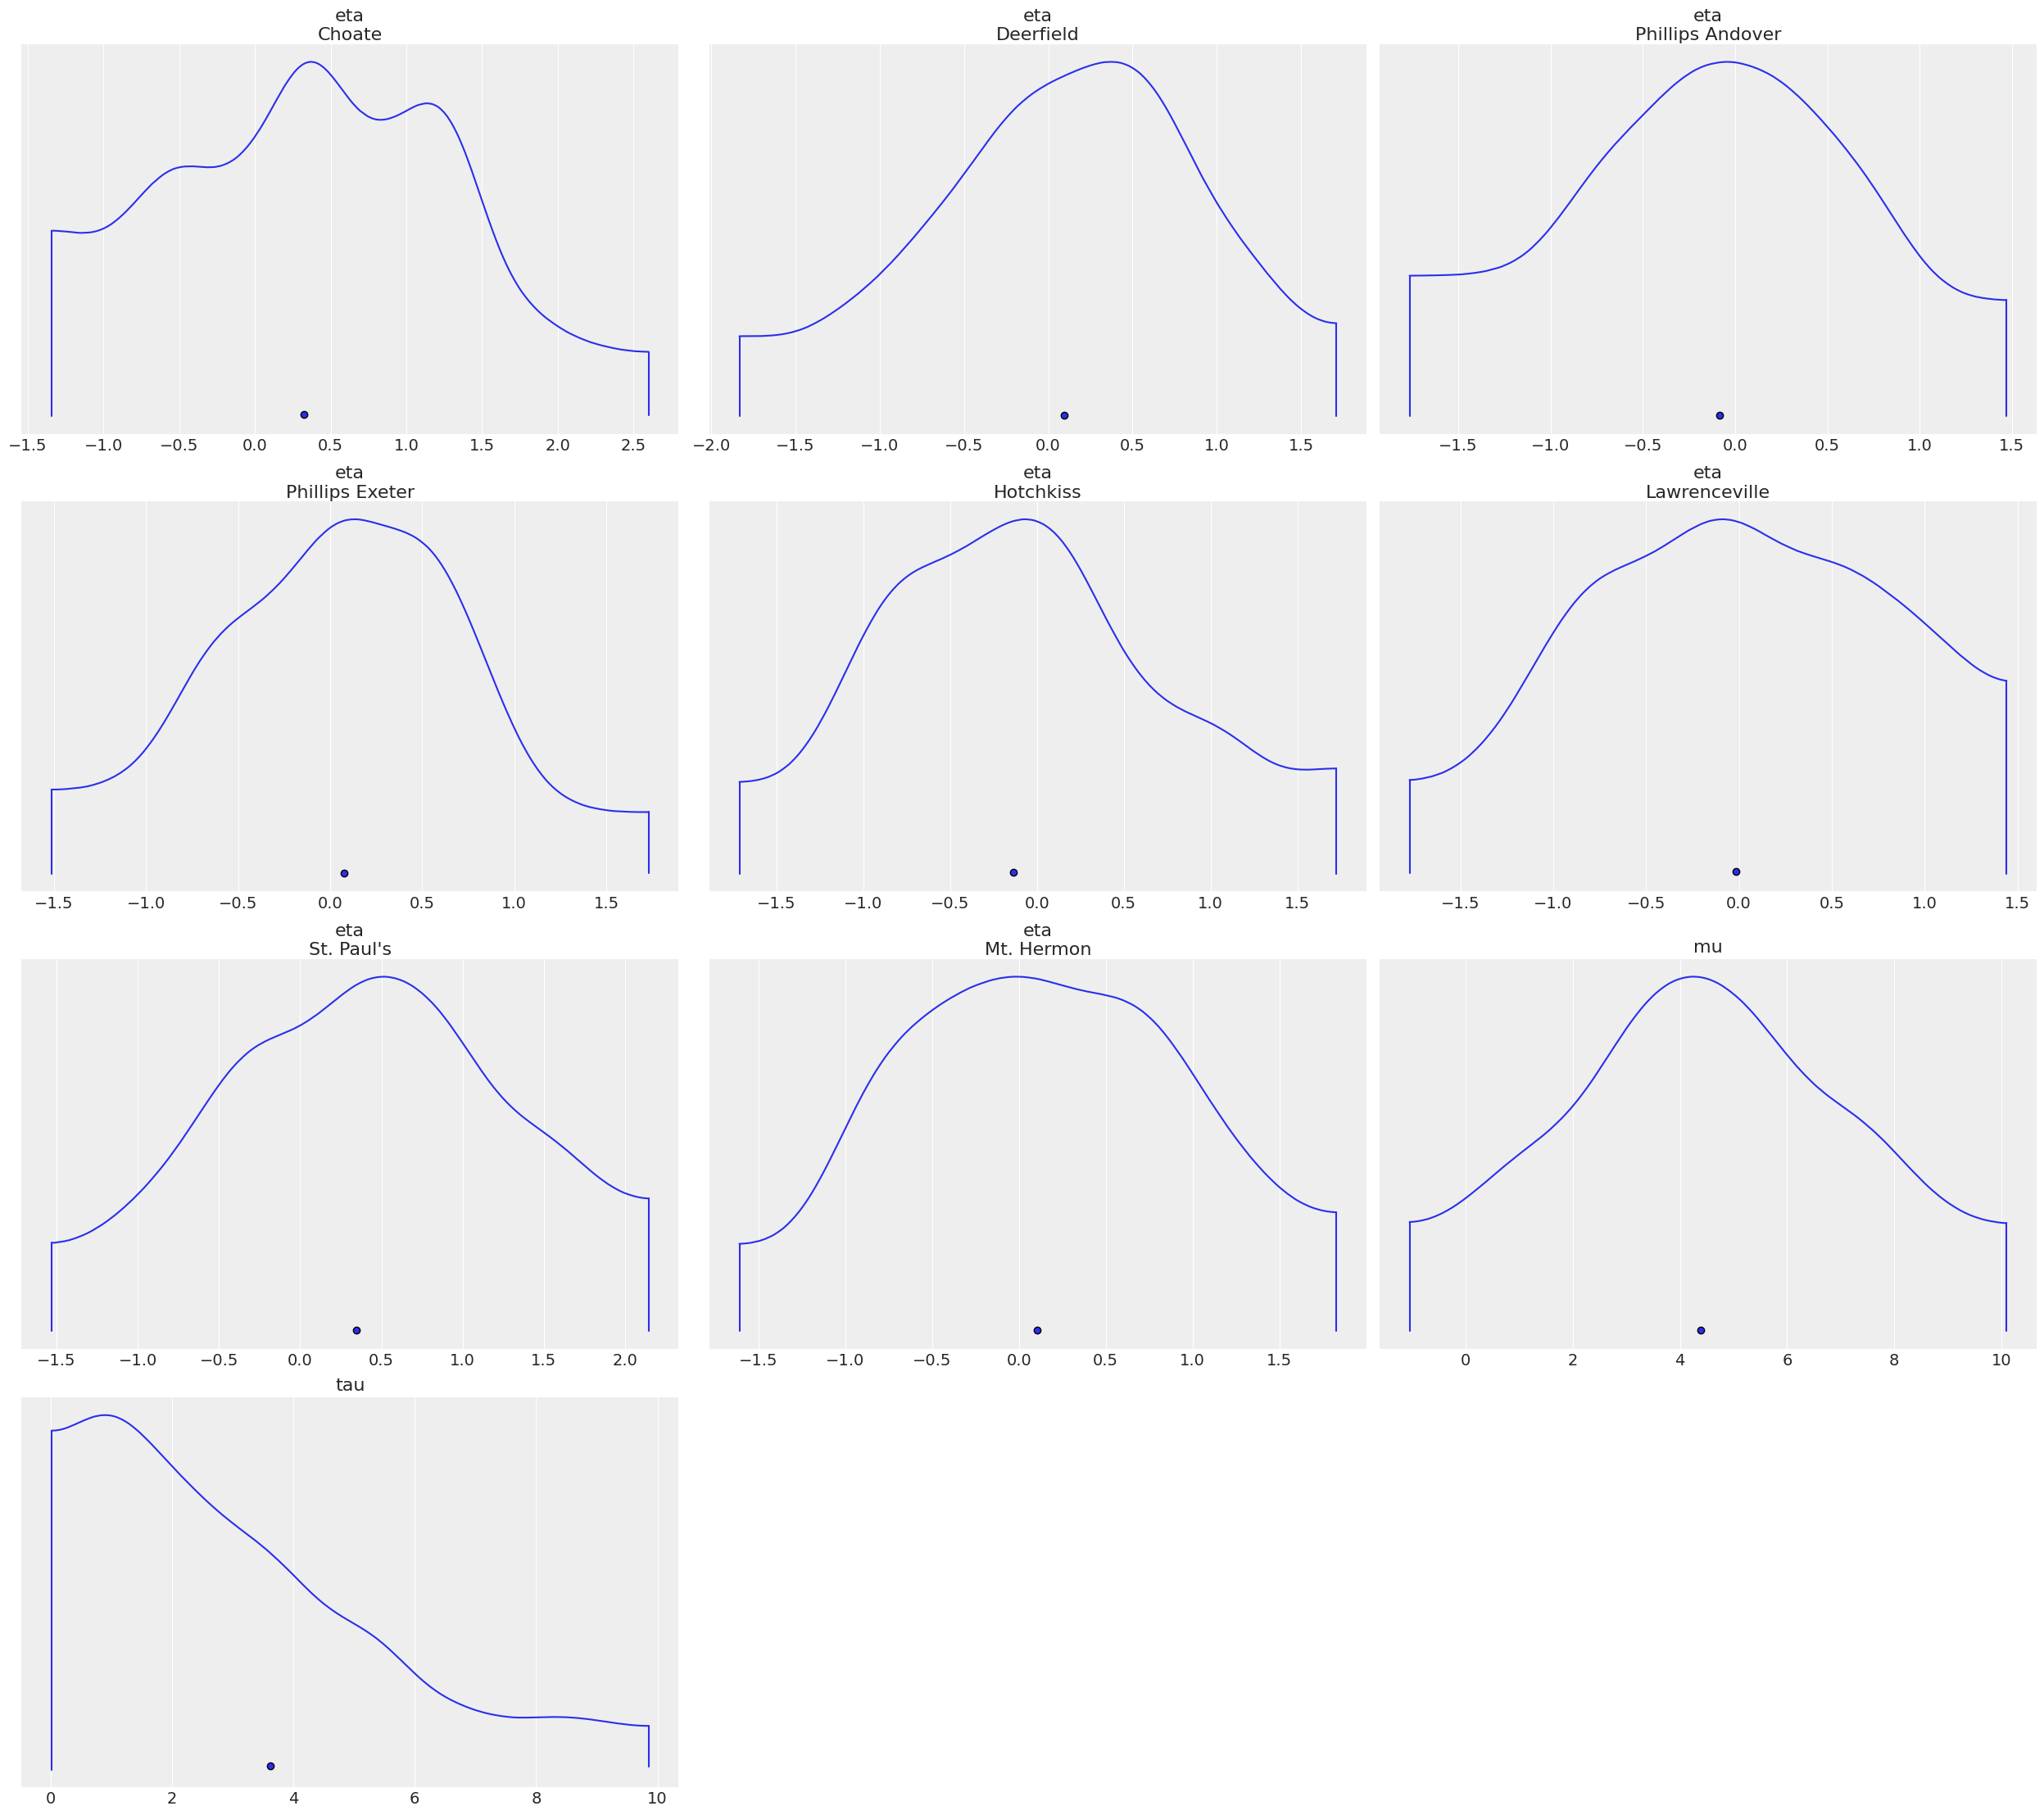

In [64]:
az.plot_density(pyro_data);

array([<AxesSubplot:title={'center':'tau\n0'}>,
       <AxesSubplot:title={'center':'mu\n0'}>], dtype=object)

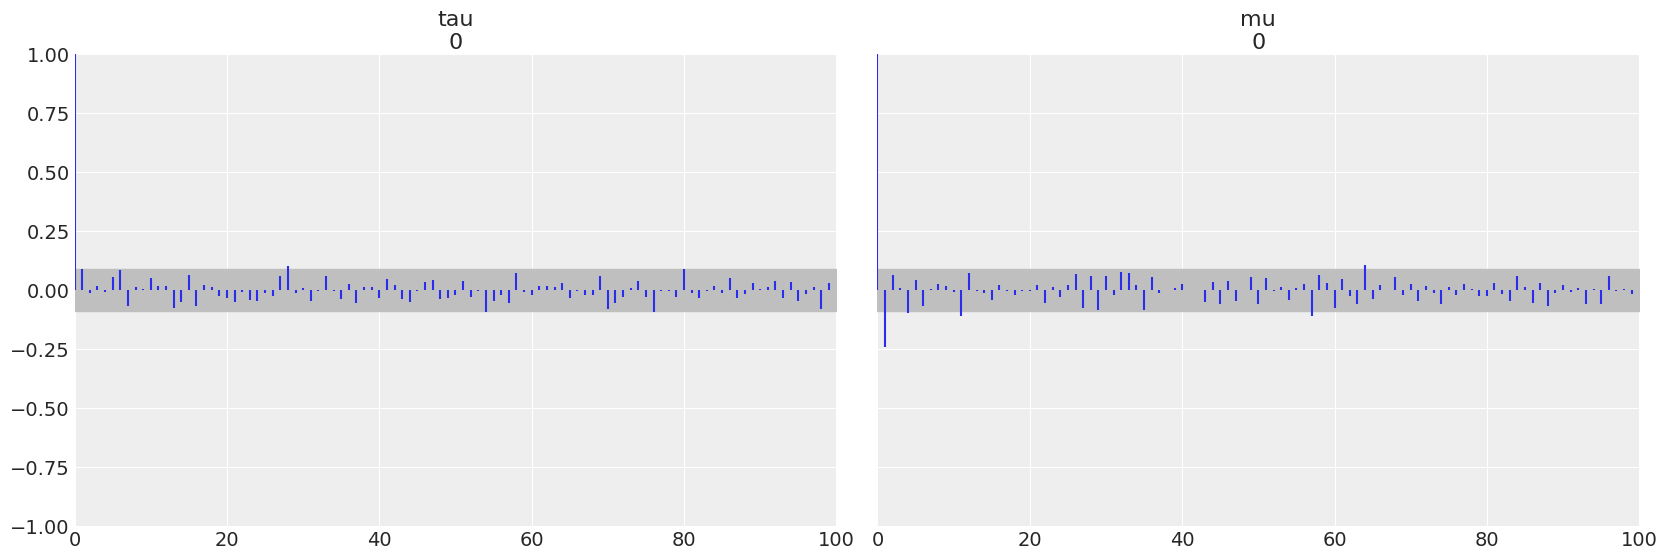

In [65]:
az.plot_autocorr(pyro_data, var_names=("tau","mu"))

In [66]:
az.plot_autocorr?

Signature:
az.plot_autocorr(
    data,
    var_names=None,
    filter_vars=None,
    max_lag=None,
    combined=False,
    grid=None,
    figsize=None,
    textsize=None,
    labeller=None,
    ax=None,
    backend=None,
    backend_config=None,
    backend_kwargs=None,
    show=None,
)
Docstring:
Bar plot of the autocorrelation function for a sequence of data.

Useful in particular for posteriors from MCMC samples which may display correlation.

Parameters
----------
data: obj
    Any object that can be converted to an :class:`arviz.InferenceData` object
    refer to documentation of :func:`arviz.convert_to_dataset` for details
var_names: list of variable names, optional
    Variables to be plotted, if None all variables are plotted. Prefix the
    variables by ``~`` when you want to exclude them from the plot. Vector-value
    stochastics are handled automatically.
filter_vars: {None, "like", "regex"}, optional, default=None
    If `None` (default), interpret var_names as the real va

array([<AxesSubplot:title={'center':'tau\n0'}>,
       <AxesSubplot:title={'center':'mu\n0'}>], dtype=object)

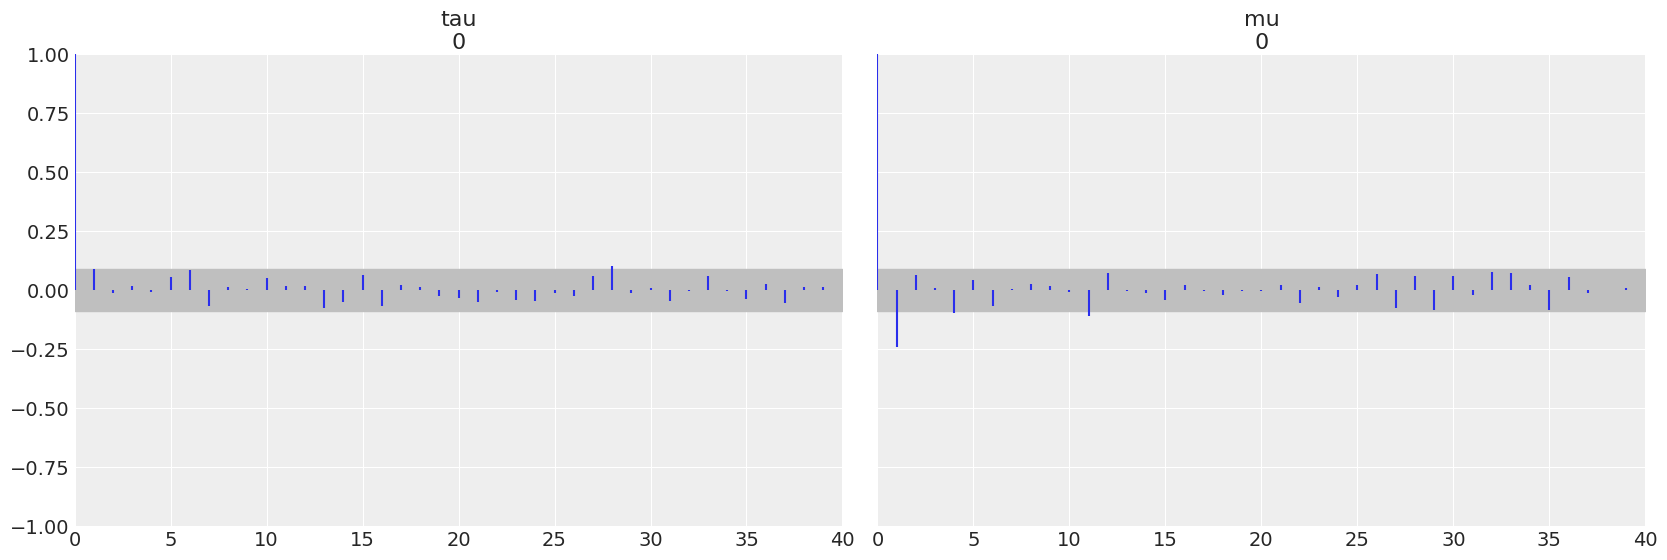

In [67]:
az.plot_autocorr(pyro_data,max_lag=40,var_names=("tau","mu"))

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

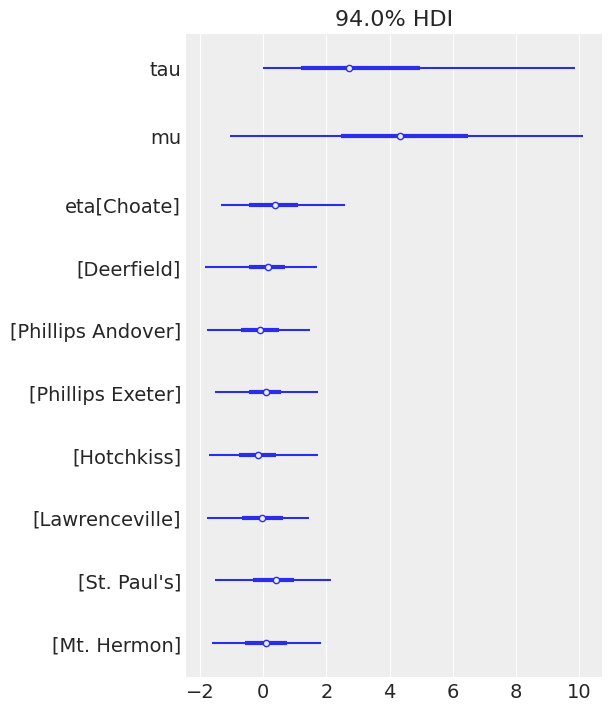

In [68]:

az.plot_forest(pyro_data, var_names=("tau","mu","eta"))

In [69]:
az.plot_forest?

Signature:
az.plot_forest(
    data,
    kind='forestplot',
    model_names=None,
    var_names=None,
    filter_vars=None,
    transform=None,
    coords=None,
    combined=False,
    combine_dims=None,
    hdi_prob=None,
    rope=None,
    quartiles=True,
    ess=False,
    r_hat=False,
    colors='cycle',
    textsize=None,
    linewidth=None,
    markersize=None,
    legend=True,
    labeller=None,
    ridgeplot_alpha=None,
    ridgeplot_overlap=2,
    ridgeplot_kind='auto',
    ridgeplot_truncate=True,
    ridgeplot_quantiles=None,
    figsize=None,
    ax=None,
    backend=None,
    backend_config=None,
    backend_kwargs=None,
    show=None,
)
Docstring:
Forest plot to compare HDI intervals from a number of distributions.

Generates a forest plot of 100*(hdi_prob)% HDI intervals from a trace or list of traces.

Parameters
----------
data: obj or list[obj]
    Any object that can be converted to an :class:`arviz.InferenceData` object
    Refer to documentation of :func:`arviz.con

array([<AxesSubplot:title={'center':'94.0% HDI'}>,
       <AxesSubplot:title={'center':'r_hat'}>], dtype=object)

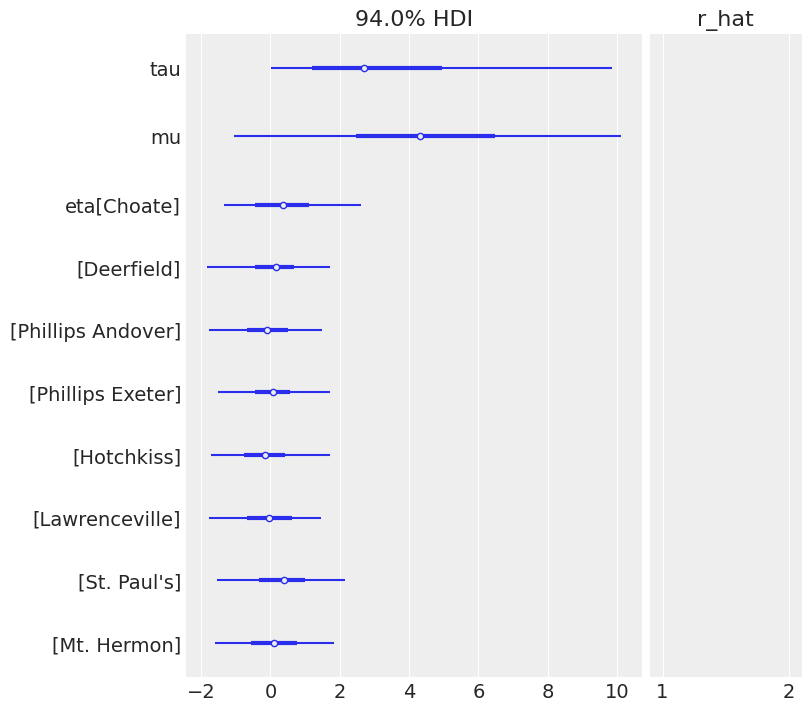

In [70]:
az.plot_forest(pyro_data, var_names=("tau","mu", "eta"),r_hat=True)

array([[<AxesSubplot:title={'center':'tau'}>,
        <AxesSubplot:title={'center':'tau'}>],
       [<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>]], dtype=object)

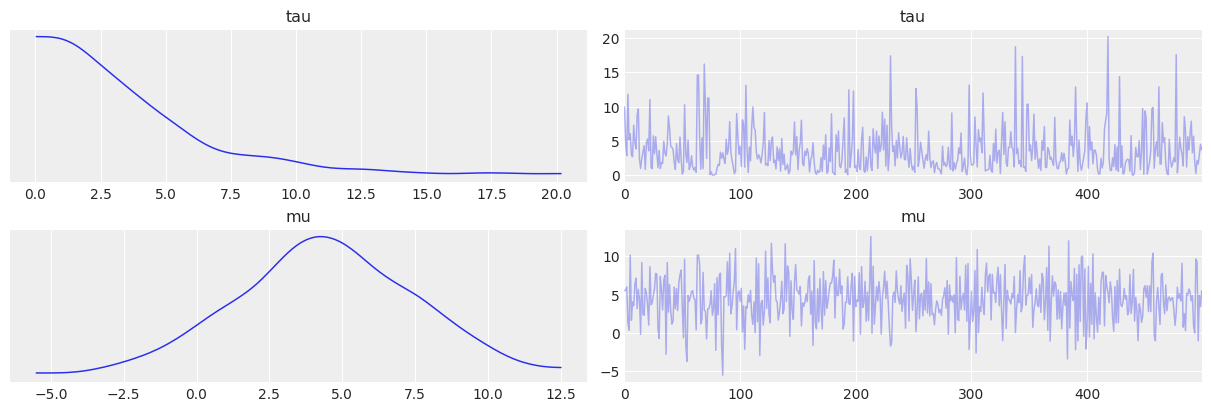

In [71]:
az.plot_trace(pyro_data, var_names=("tau","mu"))

In [72]:
az.plot_trace?

Signature:
az.plot_trace(
    data: arviz.data.inference_data.InferenceData,
    var_names: Optional[Sequence[str]] = None,
    filter_vars: Optional[str] = None,
    transform: Optional[Callable] = None,
    coords: Optional[Dict[str, List[Any]]] = None,
    divergences: Optional[str] = 'auto',
    kind: Optional[str] = 'trace',
    figsize: Optional[Tuple[float, float]] = None,
    rug: bool = False,
    lines: Optional[List[Tuple[str, Dict[str, List[Any]], Any]]] = None,
    circ_var_names: Optional[List[str]] = None,
    circ_var_units: str = 'radians',
    compact: bool = True,
    compact_prop: Union[str, Mapping[str, Any], NoneType] = None,
    combined: bool = False,
    chain_prop: Union[str, Mapping[str, Any], NoneType] = None,
    legend: bool = False,
    plot_kwargs: Optional[Dict[str, Any]] = None,
    fill_kwargs: Optional[Dict[str, Any]] = None,
    rug_kwargs: Optional[Dict[str, Any]] = None,
    hist_kwargs: Optional[Dict[str, Any]] = None,
    trace_kwargs: Optional[

array([[<AxesSubplot:title={'center':'eta\nChoate'}, xlabel='Quantile', ylabel='MCSE for quantiles'>,
        <AxesSubplot:title={'center':'eta\nDeerfield'}, xlabel='Quantile', ylabel='MCSE for quantiles'>,
        <AxesSubplot:title={'center':'eta\nPhillips Andover'}, xlabel='Quantile', ylabel='MCSE for quantiles'>],
       [<AxesSubplot:title={'center':'eta\nPhillips Exeter'}, xlabel='Quantile', ylabel='MCSE for quantiles'>,
        <AxesSubplot:title={'center':'eta\nHotchkiss'}, xlabel='Quantile', ylabel='MCSE for quantiles'>,
        <AxesSubplot:title={'center':'eta\nLawrenceville'}, xlabel='Quantile', ylabel='MCSE for quantiles'>],
       [<AxesSubplot:title={'center':"eta\nSt. Paul's"}, xlabel='Quantile', ylabel='MCSE for quantiles'>,
        <AxesSubplot:title={'center':'eta\nMt. Hermon'}, xlabel='Quantile', ylabel='MCSE for quantiles'>,
        <AxesSubplot:title={'center':'mu'}, xlabel='Quantile', ylabel='MCSE for quantiles'>],
       [<AxesSubplot:title={'center':'tau'}, xla

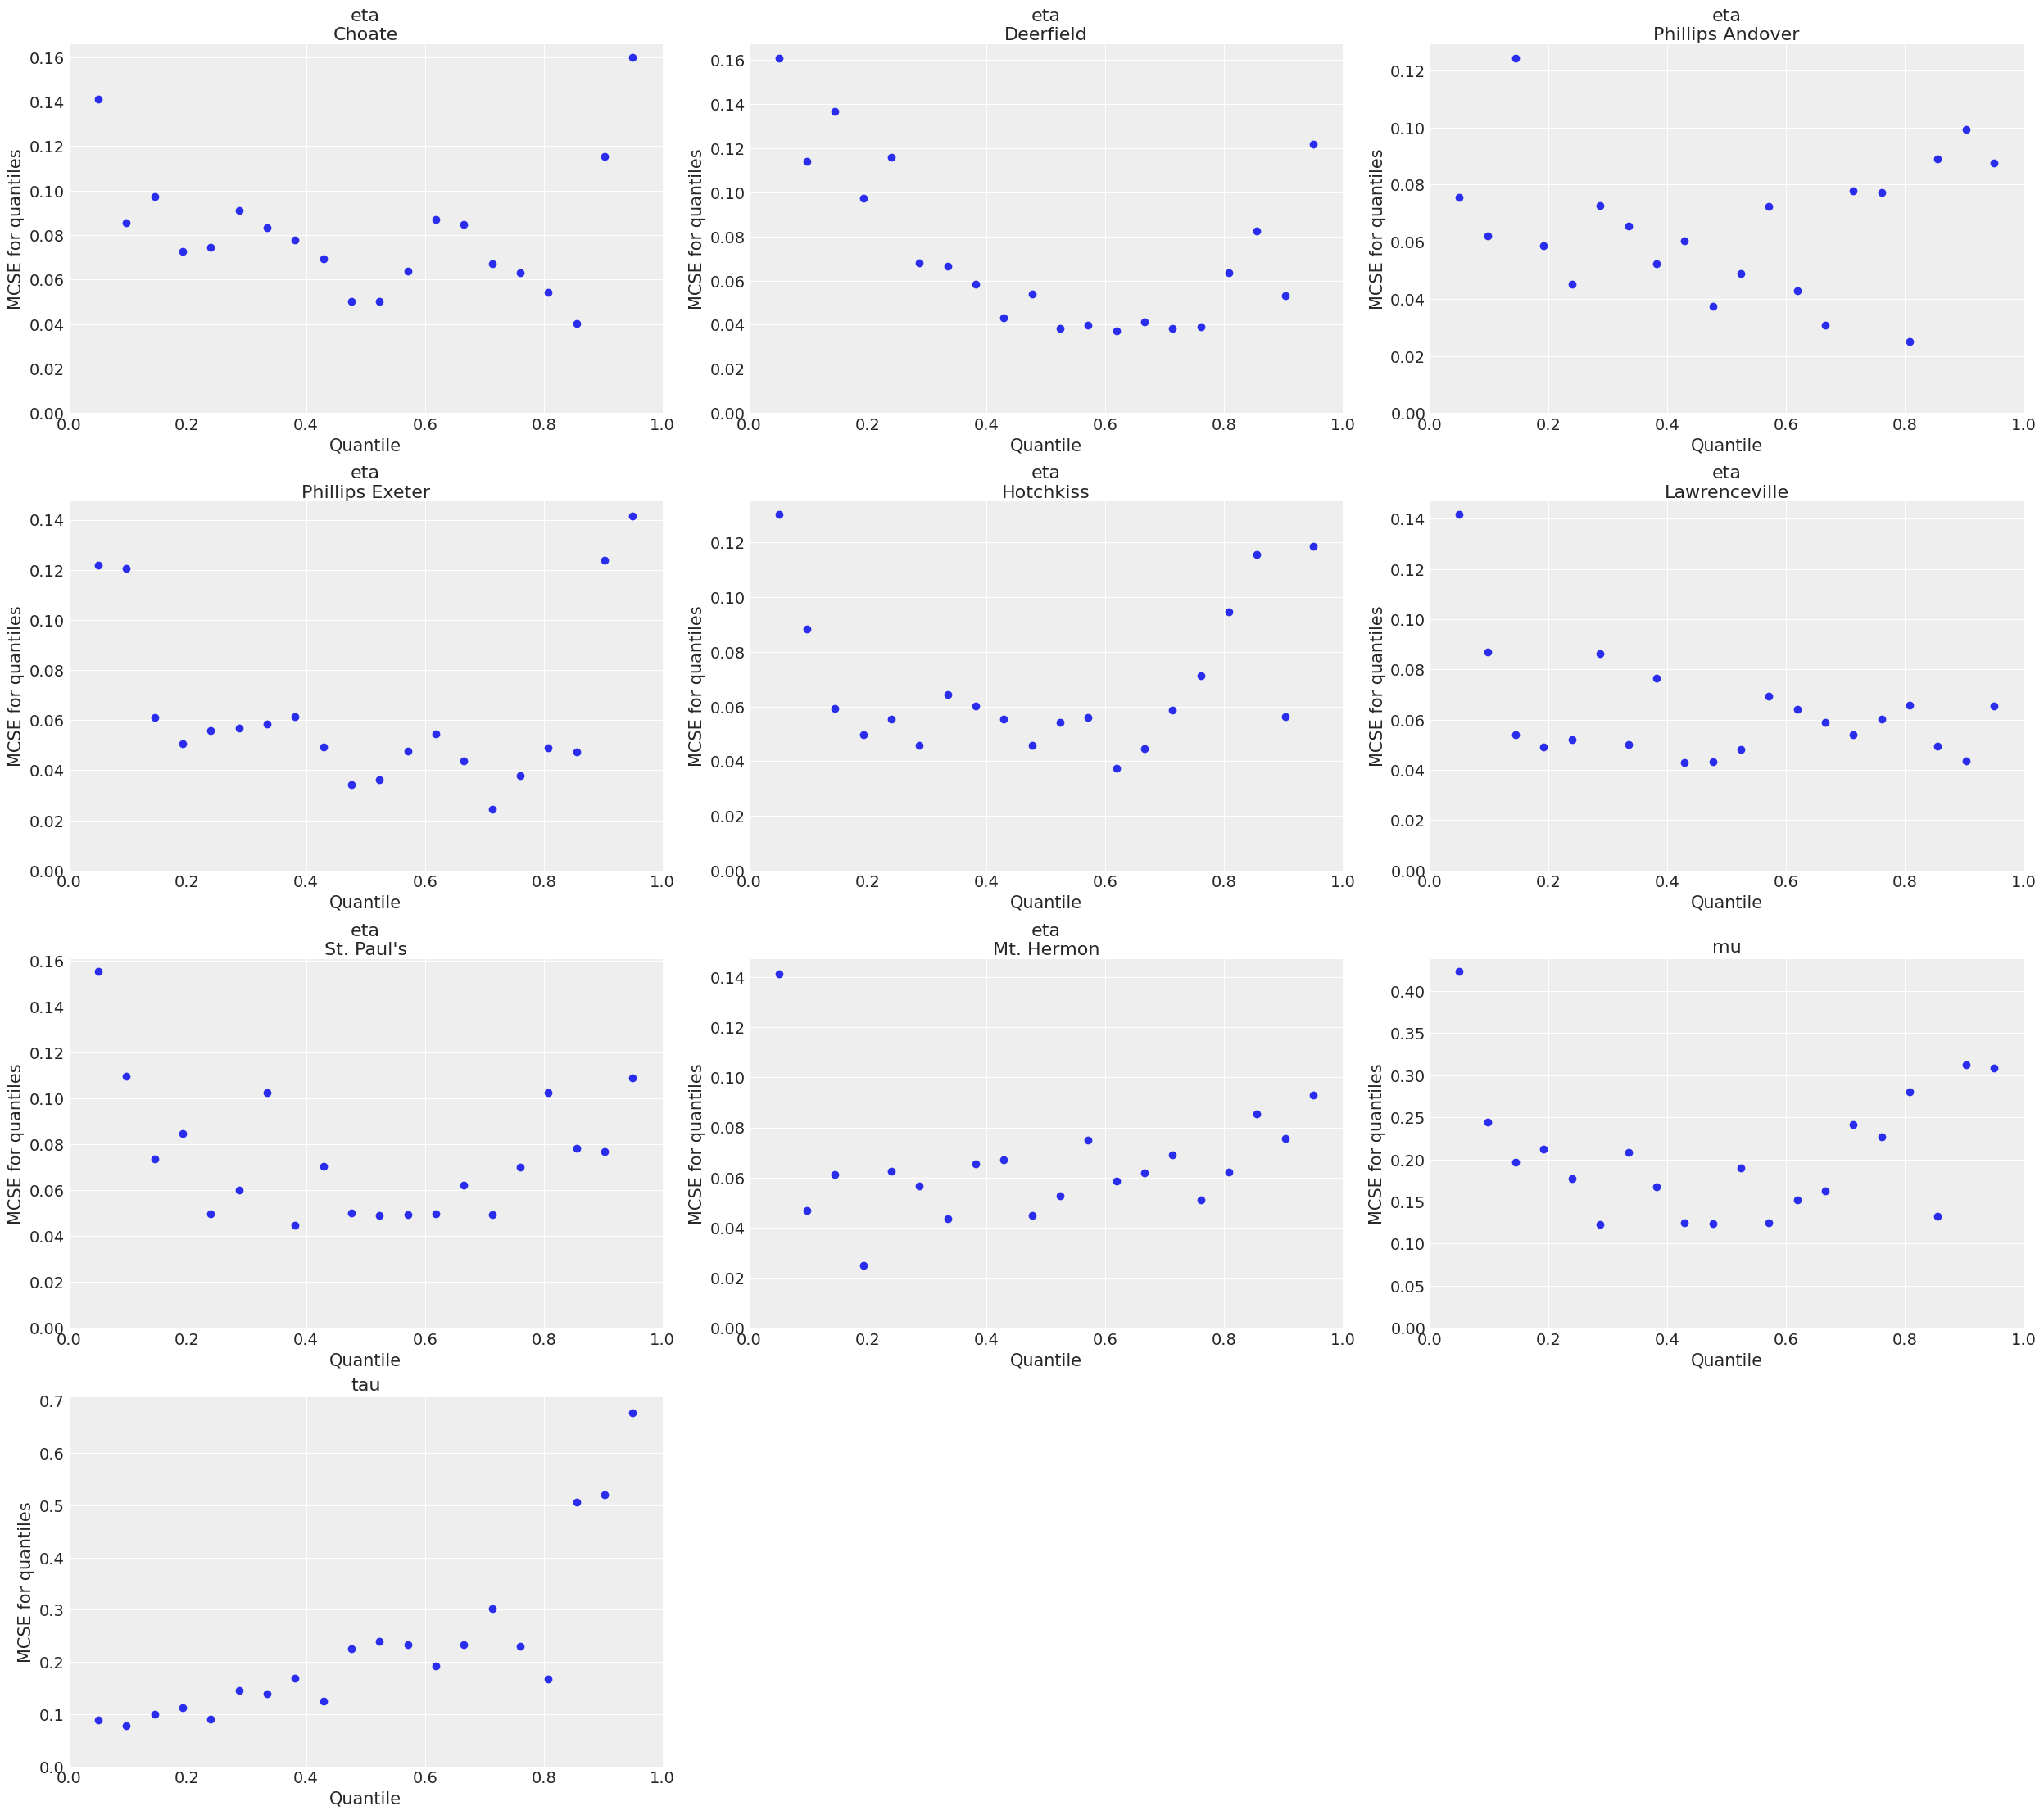

In [73]:
az.plot_mcse(pyro_data)

In [74]:
az.plot_mcse?

Signature:
az.plot_mcse(
    idata,
    var_names=None,
    filter_vars=None,
    coords=None,
    errorbar=False,
    grid=None,
    figsize=None,
    textsize=None,
    extra_methods=False,
    rug=False,
    rug_kind='diverging',
    n_points=20,
    labeller=None,
    ax=None,
    rug_kwargs=None,
    extra_kwargs=None,
    text_kwargs=None,
    backend=None,
    backend_kwargs=None,
    show=None,
    **kwargs,
)
Docstring:
Plot quantile or local Monte Carlo Standard Error.

Parameters
----------
idata: obj
    Any object that can be converted to an :class:`arviz.InferenceData` object
    Refer to documentation of :func:`arviz.convert_to_dataset` for details
var_names: list of variable names, optional
    Variables to be plotted. Prefix the variables by ``~`` when you want to exclude
    them from the plot.
filter_vars: {None, "like", "regex"}, optional, default=None
    If `None` (default), interpret var_names as the real variables names. If "like",
    interpret var_names as sub

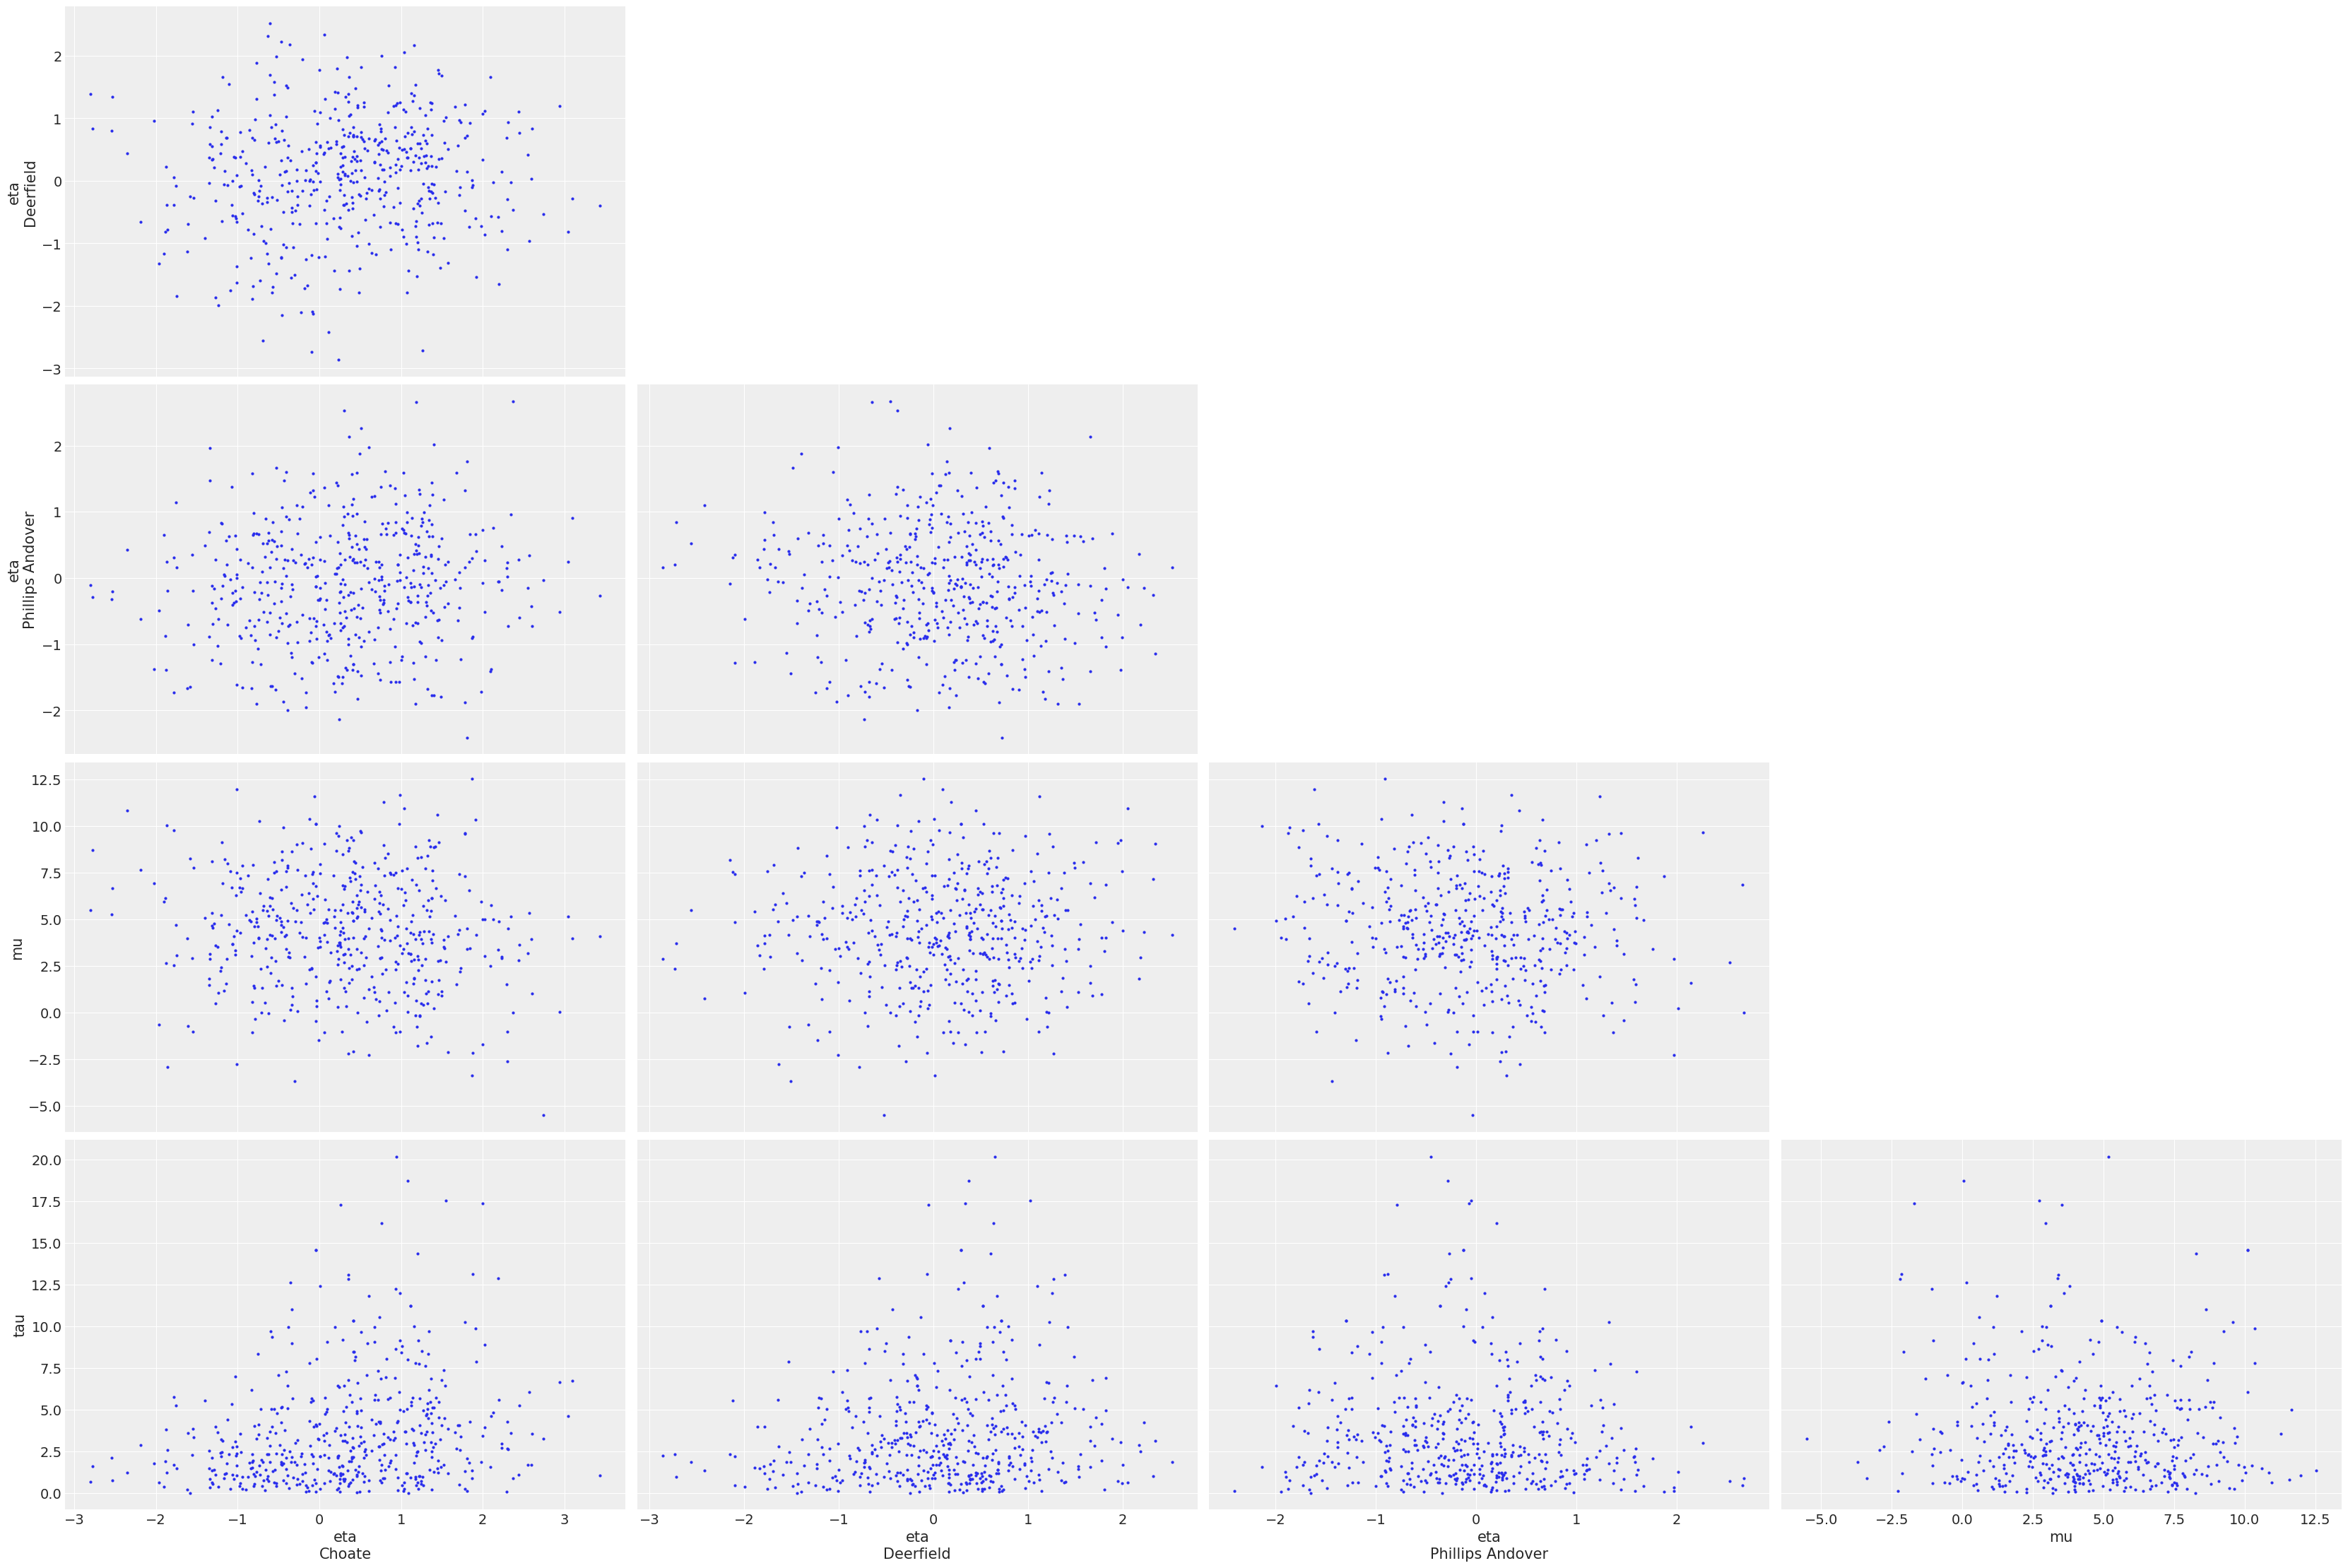

In [75]:
az.plot_pair(pyro_data, coords={"school": ['Choate', 'Deerfield', 'Phillips Andover']}, divergences=True);

In [76]:
az.geweke(pyro_data.posterior.mu[0,:])


AttributeError: module 'arviz' has no attribute 'geweke'

## <span style="color:#4361EE">Referencias</span>


- https://arviz-devs.github.io/arviz/getting_started/CreatingInferenceData.html#from-pyro